In [1]:
from itertools import product

def modularity(G, partition):
    """Returns the modularity of the partition of an undirected graph G.
    """
    m = G.size(weight="weight")
    degrees = dict(G.degree(weight="weight"))
    list_degrees = list(degrees)
    # print(partition)
    Q = 0
    for community in partition:
        for u, v in product(community, repeat=2):
            try:
                w = G[u][v].get("weight", 1)
            except KeyError:
                w = 0
            if u == v:
                # Double count self-loop weight.
                w *= 2
            Q += w - degrees[list_degrees[u]] * degrees[list_degrees[v]] / (2 * m)
    return Q / (2 * m)

In [2]:
import networkx.algorithms.community as nx_com

def modularity(G, partition):
    """Returns the modularity of the partition of an undirected graph G.
    """
    communities_sets = []
    for comm in partition:
        if comm is not None:
            communities_sets.append(frozenset(comm))
    return nx_com.modularity(G,communities_sets,weight=None)

In [3]:
from sklearn.cluster import KMeans

def multi_kmeans(G, n_clusters):
    labels = []
    comm = []

    X = nx.to_numpy_array(G)
    
    for i,c in enumerate(n_clusters) :
        kmeans = KMeans(n_clusters=c,random_state=23)
        kmeans.fit(X)
        labels.append(kmeans.labels_)

        a = []

        for b in range(c) : 
            a.append(np.argwhere(labels[i] == b).flatten().tolist())
        comm.append(a)
        
    return comm

In [4]:
import random

def generate_chrom_from_community(graph,community):
    
    A = nx.to_numpy_array(graph)
    
    ret = []
    chrom = np.zeros((A.shape[0]))

    
    for l in range(5):
        for c in community :     
            for x in c:
                rand = random.choice(c)
                #while (Adj[x,rand] != 1) or (rand not in community[i]) :
                tmp= A[x,c].flatten()
                if (len(tmp[tmp==1]) != 0):
                    while (A[x,rand] != 1):
                        rand = random.choice(c)
                else :                                # Hypothèse : this will be rendering one comm only ?? 
                    while (A[x,rand] != 1):
                        rand = random.choice(range(len(A[x])))
                chrom[x] = rand
        ret.append(chrom.astype(int))
    return ret

In [5]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

def community_detection(nodes,edges,population=50,generation=300,r=1.5):
    
    graph=nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    Adj = nx.adjacency_matrix(graph)
    nodes_length = len(graph.nodes())
    
    n_clusters = [2,3,4,5,6,7,8,9,10]
    
    commu = multi_kmeans(graph, n_clusters)
    
    
    kmeans_chrom = [generate_chrom_from_community(graph,commu[i]) for i in range(len(commu))]
    
    
    kmeans_chrom_flattened = [item for sublist in kmeans_chrom for item in sublist]


    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)] + kmeans_chrom_flattened}
    dframe = pd.DataFrame(data= d)
    dframe["subsets"] = dframe["chrom"].apply(find_subsets)
    dframe["community_score"]= dframe.apply(lambda x: modularity(graph,x['subsets']),axis=1)
    
    index = dframe.sort_values("community_score",ascending=False).index[0]
    

    
    gen = 0
    population_count = population
    
    best_comm = dframe["subsets"][index]
    best_mod =  dframe["community_score"][index]
    
    start = time.time()
    while gen < generation:
        for i in range(int(np.floor(population/10))):
            p1 = 0
            p2 = 0
            elites = dframe.sort_values("community_score",ascending=True)[int(np.floor(population/10)):]
            p1 = roulette_selection(elites)
            p2 = roulette_selection(elites)
            child=uniform_crossover(dframe["chrom"][p1],dframe["chrom"][p2],1)
            if len(child)==0:
                continue
            child=mutation(child,Adj,1)
            child_subsets = find_subsets(child)       
            child_cs = modularity(graph,child_subsets)

            dframe.loc[population_count]=[child,child_subsets,child_cs]
            population_count += 1
        dfsorted = dframe.sort_values("community_score",ascending=False)
        to_drop = dfsorted.index[population:]
        dframe.drop(to_drop,inplace=True)
        gen +=1        
    sorted_df = dframe.sort_values("community_score",ascending=False).index[0]
    print(dframe.sort_values("community_score",ascending=False).head(5)["community_score"])
    nodes_subsets = dframe["subsets"][sorted_df]
    
    nodes_list = list(graph.nodes())

#    result = []    
#     for subs in nodes_subsets:
#         subset = []
#         for n in subs:
#             subset.append(nodes_list[n])
#         result.append(subset)

    end = time.time()
    
    print("It Took ",end - start)

    return nodes_subsets

def generate_chrom(nodes_length,Adj):
    chrom = np.array([],dtype=int)
    for x in range(nodes_length):
        rand = np.random.randint(0,nodes_length)
        while Adj[x,rand] != 1:
            rand = np.random.randint(0,nodes_length)
        chrom = np.append(chrom,rand)
    return chrom

def merge_subsets(sub):
    arr =[]
    to_skip=[]
    for s in range(len(sub)):
        if sub[s] not in to_skip:
            new = sub[s]
            for x in sub:
                if sub[s] & x:
                    new = new | x
                    to_skip.append(x)
            arr.append(new)
    return arr

def find_subsets(chrom):
    sub = [{x,chrom[x]} for x in range(len(chrom))]
    result=sub
    i=0
    while i<len(sub):
        candidate = merge_subsets(result)
        if candidate != result:
            result = candidate
        else:
            break
        result=candidate
        i+=1
        
        
    if sum([len(c) for c in result]) != len(chrom):
        print('\n wrooooong \n',len(chrom),chrom,sub,sum([len(c) for c in result]),result)
        
    return result

def community_score(chrom,subsets,r,Adj):
    matrix = Adj.toarray()
    CS=0
    for s in subsets:
        submatrix = np.zeros((len(chrom),len(chrom)),dtype=int)
        for i in s:
            for j in s:
                submatrix[i][j]=matrix[i][j]
        M=0
        v=0
        for row in list(s):
            row_mean = np.sum(submatrix[row])/len(s)
            v+=np.sum(submatrix[row])
            M+=(row_mean**r)/len(s)
        CS+=M*v
    return CS

def roulette_selection(df_elites):
    prob = np.random.random_sample()
    sum_cs=np.sum(df_elites["community_score"])
    x=0
    selected = 0
    for i in df_elites.index:
        x += df_elites["community_score"][i]
        X=x/sum_cs
        if prob < X:
            chosen=i
            break
    return chosen

def uniform_crossover(parent_1,parent_2,crossover_rate):
    if np.random.random_sample() < crossover_rate:
        length = len(parent_1)
        mask = np.random.randint(2, size=length)
        child = np.zeros(length,dtype=int)
        for i in range(len(mask)):
            if mask[i] == 1:
                child[i]=parent_1[i]
            else:
                child[i]=parent_2[i]
        return child
    else:
        return np.array([])

def mutation(chrom,Adj,mutation_rate):
    if np.random.random_sample() < mutation_rate:
        chrom = chrom
        neighbor = []
        while len(neighbor) < 2:
            mutant = np.random.randint(1,len(chrom))
            row = Adj[mutant].toarray()[0]
            neighbor = [i for i in range(len(row)) if row[i]==1]
            if len(neighbor) > 1:
                neighbor.remove(chrom[mutant])
                to_change=int(np.floor(np.random.random_sample()*(len(neighbor))))
                chrom[mutant]=neighbor[to_change]
                neighbor.append(chrom[mutant])
    return chrom


In [6]:
def draw_communities(G,communities, node_size=30, alpha=1, k=None, randomized=False):


    community_map = {}
    i=0
    for c in communities :
        for n in c :
            community_map[n] = i
        i+=1

    cmap = plt.get_cmap("jet")
    pos = nx.spring_layout(G)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")

    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)

### Football

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


2741    0.60457
5017    0.60457
4998    0.60457
5000    0.60457
5001    0.60457
Name: community_score, dtype: float64
It Took  26.678037405014038


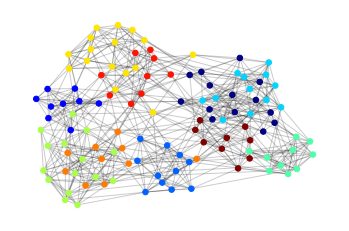

In [7]:
graph = nx.read_gml('football.gml',label='id')
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50,r=2)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


1076    0.603162
1500    0.603162
1477    0.603162
1479    0.603162
1480    0.603162
Name: community_score, dtype: float64
The result:
[{0, 4, 7, 8, 9, 11, 16, 21, 22, 23, 24, 28, 41, 50, 51, 68, 69, 77, 78, 90, 93, 104, 108, 111}, {89, 1, 33, 37, 103, 105, 109, 45, 25}, {64, 32, 2, 100, 6, 39, 106, 13, 15, 47, 60}, {98, 3, 5, 102, 72, 40, 10, 74, 107, 81, 84, 52}, {34, 99, 36, 38, 71, 42, 43, 12, 14, 18, 85, 54, 26, 61, 31}, {65, 66, 70, 75, 76, 17, 20, 86, 87, 27, 92, 91, 95, 96, 97, 44, 48, 113, 112, 56, 57, 58, 59, 62, 63}, {35, 101, 79, 80, 82, 19, 30, 55, 29, 94}, {67, 73, 46, 110, 49, 114, 83, 53, 88}]
It Took  12.271937131881714


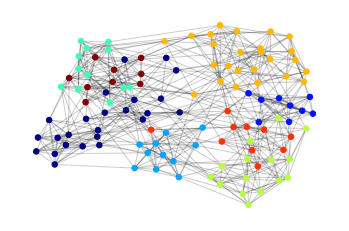

In [128]:
graph = nx.read_gml('football.gml',label='id')
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=300,population=50,r=2)
draw_communities(graph,comm)


In [142]:
check_double(comm)

[]

### Dauphin graph

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


1339    0.528519
2030    0.528519
2012    0.528519
2015    0.528519
2016    0.528519
Name: community_score, dtype: float64
It Took  11.060947179794312


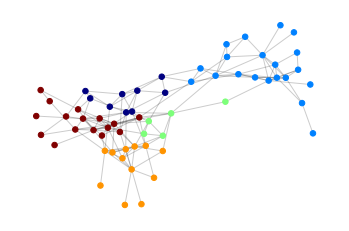

In [19]:
graph = nx.read_gml('dolphins.gml', label='id')
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=500,population=50,r=2)

draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


3904    0.527728
5013    0.527728
4992    0.527728
4996    0.527728
4997    0.527728
Name: community_score, dtype: float64
It Took  18.201388359069824


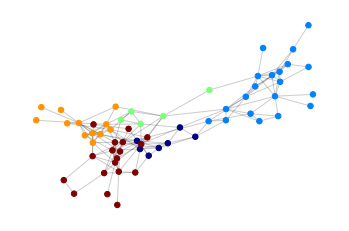

In [8]:
graph = nx.read_gml('dolphins.gml', label='id')
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50,r=2)

draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


982     0.526463
2503    0.526463
2478    0.526463
2483    0.526463
2485    0.526463
Name: community_score, dtype: float64
The result:
[{0, 2, 10, 42, 28, 30, 47}, {1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 39, 41, 48, 54, 56, 57, 60}, {3, 4, 8, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55, 59}, {12, 14, 16, 20, 33, 34, 36, 37, 38, 40, 43, 44, 46, 49, 50, 52, 53, 58, 61}]
It Took  13.450028896331787


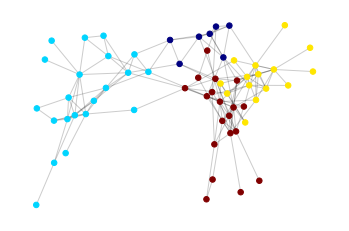

In [143]:
graph = nx.read_gml('dolphins.gml', label='id')
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=500,population=50,r=2)

draw_communities(graph,comm)

### Karate graph

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


201     0.41979
1520    0.41979
1497    0.41979
1498    0.41979
1501    0.41979
Name: community_score, dtype: float64
It Took  4.667354345321655


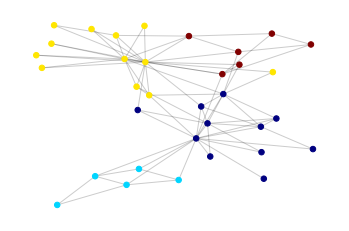

In [9]:
G = nx.karate_club_graph()
nodes = G.nodes()
edges = G.edges()


comm = community_detection(nodes,edges,generation=300,population=50)
draw_communities(G,comm)

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


1910    0.544297
4013    0.544297
3994    0.544297
3995    0.544297
3997    0.544297
Name: community_score, dtype: float64
It Took  28.365338563919067


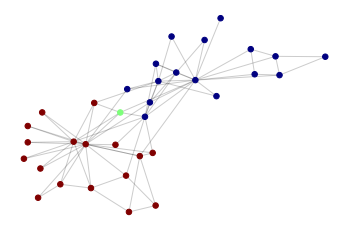

In [9]:
G = nx.karate_club_graph()
nodes = G.nodes()
edges = G.edges()


comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(G,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


276     0.543475
1247    0.543475
1232    0.543475
1234    0.543475
1235    0.543475
Name: community_score, dtype: float64
It Took  4.924675226211548


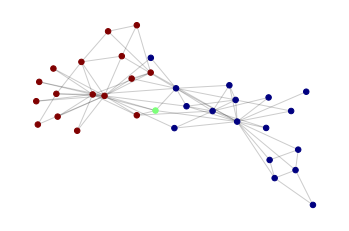

In [25]:
G = nx.karate_club_graph()
nodes = G.nodes()
edges = G.edges()


comm = community_detection(nodes,edges,generation=300,population=50)
draw_communities(G,comm)

# Synthetic data

# 0.1

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4950    0.291016
4915    0.290527
5000    0.290527
4231    0.286011
4988    0.286011
Name: community_score, dtype: float64
It Took  29.066233158111572


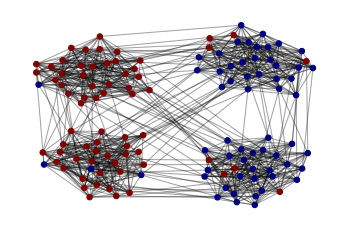

In [10]:
import pandas as pd

d = pd.read_csv("benchmarks/0.1/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4922    0.195312
5041    0.193359
5038    0.189087
4981    0.188965
4944    0.188965
Name: community_score, dtype: float64
It Took  29.235387802124023


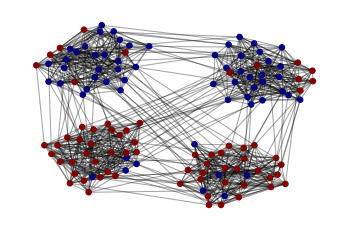

In [11]:
d = pd.read_csv("benchmarks/0.1/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4905    0.263184
4975    0.261719
4931    0.255371
5038    0.255371
5023    0.255371
Name: community_score, dtype: float64
It Took  29.219391345977783


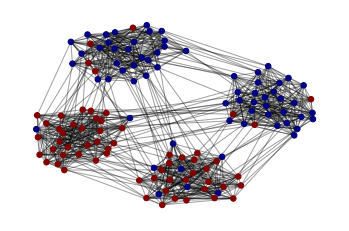

In [12]:
d = pd.read_csv("benchmarks/0.1/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4390    0.264282
4990    0.264282
4952    0.264282
4955    0.264282
4956    0.264282
Name: community_score, dtype: float64
It Took  28.737194776535034


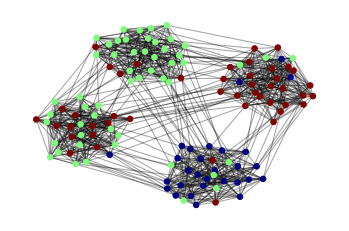

In [13]:
d = pd.read_csv("benchmarks/0.1/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

# 0.2

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


5016    0.225464
4782    0.225464
4904    0.225464
5008    0.225464
5019    0.225464
Name: community_score, dtype: float64
It Took  29.60926055908203


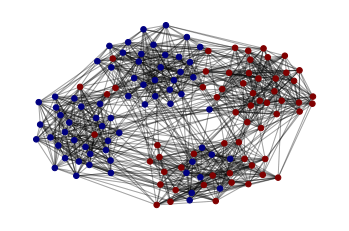

In [14]:
d = pd.read_csv("benchmarks/0.2/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4960    0.217651
4948    0.216309
4942    0.216309
5029    0.216309
5010    0.214722
Name: community_score, dtype: float64
It Took  29.93028497695923


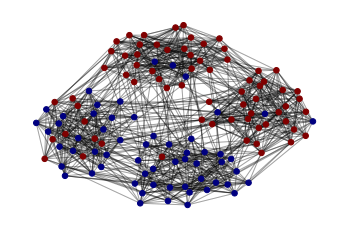

In [15]:
d = pd.read_csv("benchmarks/0.2/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4959    0.197876
5047    0.197754
5037    0.197754
5000    0.194946
4987    0.194214
Name: community_score, dtype: float64
It Took  29.82627272605896


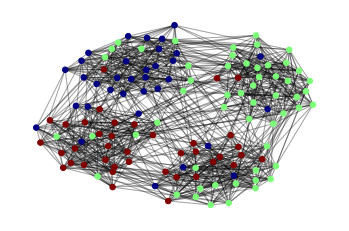

In [16]:
d = pd.read_csv("benchmarks/0.2/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

# 0.3

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4830    0.147339
4943    0.143433
5009    0.143433
4944    0.143433
4993    0.142578
Name: community_score, dtype: float64
It Took  29.591258764266968


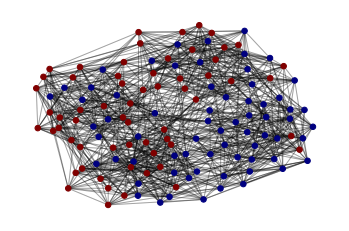

In [17]:
d = pd.read_csv("benchmarks/0.3/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


5004    0.163208
5032    0.162720
5045    0.162231
4644    0.162231
5023    0.162231
Name: community_score, dtype: float64
It Took  29.661264419555664


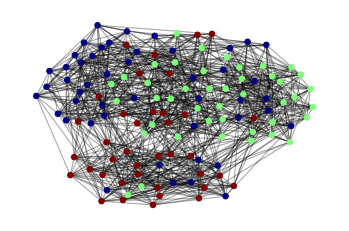

In [18]:
d = pd.read_csv("benchmarks/0.3/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


5022    0.133423
4692    0.133179
4994    0.133179
5049    0.132202
5012    0.132202
Name: community_score, dtype: float64
It Took  29.682265281677246


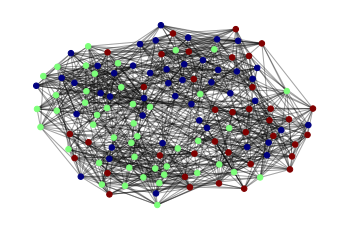

In [19]:
d = pd.read_csv("benchmarks/0.3/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

# 0.4

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4532    0.132812
5025    0.132812
4801    0.132812
4817    0.132812
5007    0.132690
Name: community_score, dtype: float64
It Took  31.777425527572632


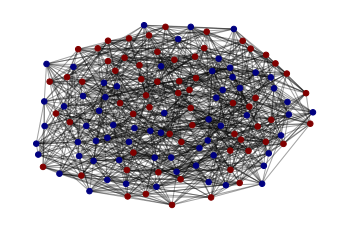

In [20]:
d = pd.read_csv("benchmarks/0.4/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4870    0.130371
4890    0.130371
4937    0.130371
4888    0.130249
4911    0.130249
Name: community_score, dtype: float64
It Took  33.68356919288635


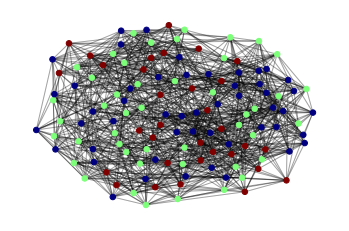

In [21]:
d = pd.read_csv("benchmarks/0.4/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


5048    0.142456
4917    0.142456
4906    0.142456
4955    0.142090
4963    0.142090
Name: community_score, dtype: float64
It Took  31.061370849609375


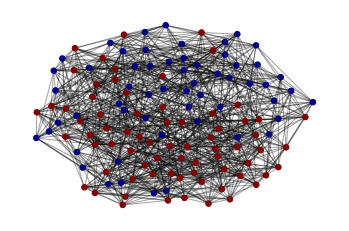

In [22]:
d = pd.read_csv("benchmarks/0.4/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

# 0.5

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


5046    0.139526
5037    0.134521
5003    0.133911
4977    0.133423
5028    0.133423
Name: community_score, dtype: float64
It Took  29.459264993667603


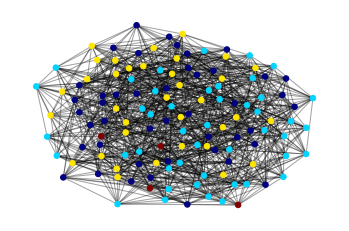

In [23]:
d = pd.read_csv("benchmarks/0.5/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4980    0.117798
4958    0.117798
5033    0.117798
5045    0.117310
5043    0.116333
Name: community_score, dtype: float64
It Took  29.59125828742981


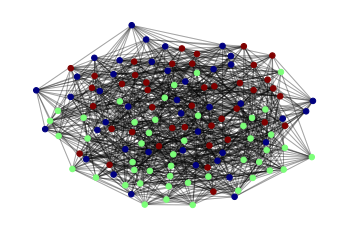

In [24]:
d = pd.read_csv("benchmarks/0.5/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


5012    0.120605
4318    0.119995
4997    0.119995
4978    0.119995
4980    0.119995
Name: community_score, dtype: float64
It Took  28.928207397460938


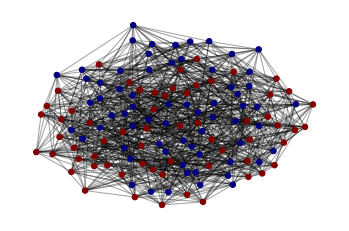

In [25]:
d = pd.read_csv("benchmarks/0.5/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

# 0.6

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4760    0.108276
5037    0.106934
4781    0.106934
5034    0.106323
5030    0.106323
Name: community_score, dtype: float64
It Took  29.517253637313843


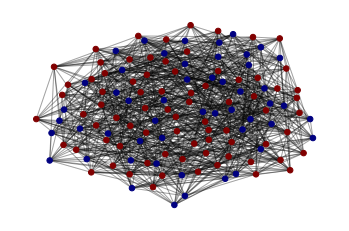

In [26]:
d = pd.read_csv("benchmarks/0.6/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


5000    0.110718
4930    0.110474
4655    0.109253
4990    0.109253
4695    0.109131
Name: community_score, dtype: float64
It Took  29.173216581344604


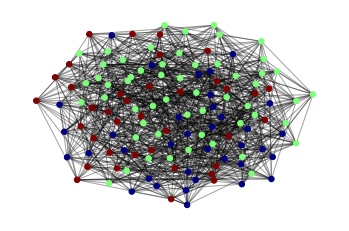

In [27]:
d = pd.read_csv("benchmarks/0.6/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4964    0.124390
4965    0.122437
5005    0.122437
4773    0.122437
4968    0.122437
Name: community_score, dtype: float64
It Took  29.392179489135742


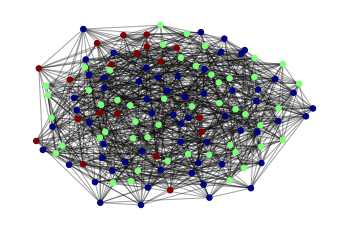

In [28]:
d = pd.read_csv("benchmarks/0.6/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

# 0.7

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4999    0.127808
4936    0.127319
4948    0.126831
4959    0.126465
4909    0.126465
Name: community_score, dtype: float64
It Took  29.80627703666687


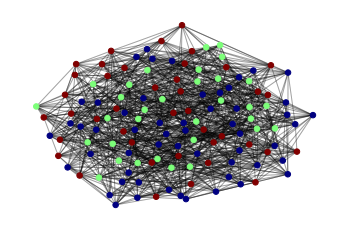

In [29]:
d = pd.read_csv("benchmarks/0.7/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4861    0.116699
5011    0.116577
4929    0.116577
5030    0.116333
4987    0.116333
Name: community_score, dtype: float64
It Took  29.922283172607422


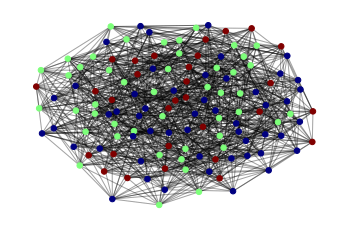

In [30]:
d = pd.read_csv("benchmarks/0.7/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


5046    0.128296
5048    0.127441
4996    0.127441
4917    0.124878
4843    0.124634
Name: community_score, dtype: float64
It Took  29.700254678726196


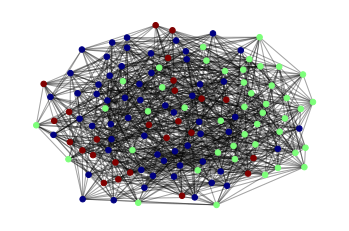

In [31]:
d = pd.read_csv("benchmarks/0.7/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

# 0.8

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4860    0.137207
4923    0.137207
5019    0.136597
4935    0.136597
4497    0.136353
Name: community_score, dtype: float64
It Took  29.50825262069702


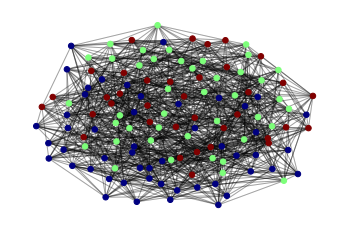

In [32]:
d = pd.read_csv("benchmarks/0.8/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


5013    0.138184
5002    0.137207
5006    0.137207
5046    0.136597
4924    0.135864
Name: community_score, dtype: float64
It Took  29.599246501922607


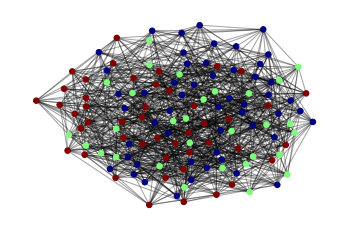

In [33]:
d = pd.read_csv("benchmarks/0.8/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4848    0.119141
4736    0.118042
4718    0.118042
5016    0.117065
4999    0.116699
Name: community_score, dtype: float64
It Took  29.381240844726562


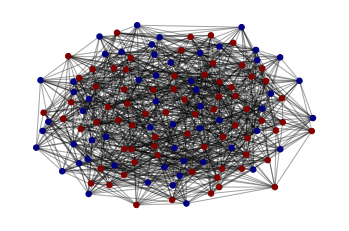

In [34]:
d = pd.read_csv("benchmarks/0.8/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

# 0.9

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4909    0.121948
4952    0.121704
5014    0.121704
4473    0.121704
5006    0.121704
Name: community_score, dtype: float64
It Took  29.513254642486572


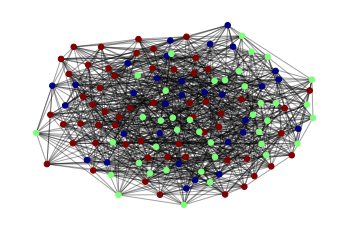

In [35]:
d = pd.read_csv("benchmarks/0.9/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


4973    0.121704
5027    0.121216
4993    0.121216
4838    0.120605
5045    0.120605
Name: community_score, dtype: float64
It Took  29.132224082946777


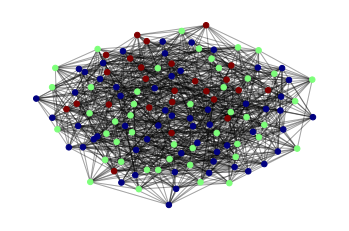

In [36]:
d = pd.read_csv("benchmarks/0.9/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

C:\Users\Rasta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


5007    0.116821
5014    0.116333
4976    0.116333
4856    0.116333
5017    0.116089
Name: community_score, dtype: float64
It Took  29.52227520942688


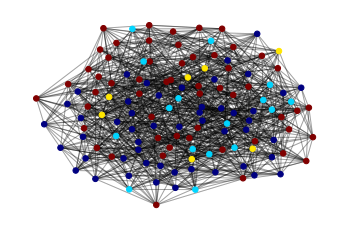

In [37]:
d = pd.read_csv("benchmarks/0.9/network.dat", sep='\t', header=None)

d[0] = d[0].apply(lambda x: int(x)-1)
d[1] = d[1].apply(lambda x: int(x)-1)

graph = nx.MultiGraph()
nx.from_pandas_edgelist(d,0,1, create_using=graph)
nodes = graph.nodes()
edges = graph.edges()

comm = community_detection(nodes,edges,generation=1000,population=50)
draw_communities(graph,comm)

# Utils

In [40]:
from collections import Counter

def check_double(ci):
    akli = [] 
    for r in ci :
        akli = akli + list(r)        
    a = [item for item, count in Counter(akli).items() if count > 1]   
    return a

In [75]:
def comm_to_frozenset(co):
    communities_sets= []
    for p in co :
        communities_sets.append(frozenset(p))
    return communities_sets